In [7]:
import pandas as pd
import json
import numpy as np

from wordcloud import WordCloud
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
def load_data(data_path):
    print('Loading data...')
    with open(data_path, 'r') as f:
        data = json.load(f)
    return data
data = load_data('./input/train.json')

Loading data...


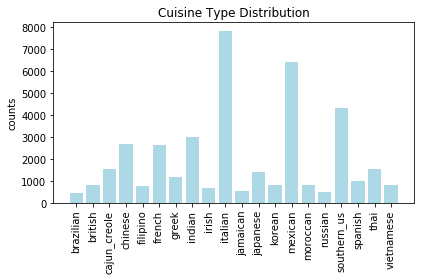

In [8]:
from collections import Counter
x = list(Counter(labels).keys())
y = list(Counter(labels).values())
fig, ax = plt.subplots()
ax.bar(x, y, color='lightblue')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_, fontsize=10, rotation=90)
ax.set_ylabel('counts')
ax.set_title('Cuisine Type Distribution')
plt.tight_layout()
#fig.savefig('cuisine_distribution.png')
plt.show()   

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_data(data, flag=None):
    ingredients = [line['ingredients'] for line in data]
    ingredients =[' '.join(i) for i in ingredients] #convert lists of words to sentences
    if flag == 'test':
        return np.asarray(ingredients)
    else:
        cuisine = [line['cuisine'] for line in data]
        le = LabelEncoder()
        labels = le.fit_transform(cuisine) #convert cuisine to categorical labels
        return np.asarray(ingredients), labels, le

def tfidf_transform(ingredients): 
    tfidf = TfidfVectorizer(min_df=5, binary=True,
                            ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(ingredients)
    return features, tfidf

ingredients, labels, le = extract_data(data)
features, tfidf = tfidf_transform(ingredients)

In [12]:
def feature_selection(features, labels, tfidf, le):
    print('Feature selection...')
    N = 4 #select the most correlated four ingredients
    cuisine_list=[] #list of all cuisine names
    com_unigram_list=[] #list of most correlated ingredients of each cuisine
    feature_names = tfidf.get_feature_names()
    cuisine_list = le.classes_
    for i in range(len(cuisine_list)):
        features_chi2 = chi2(features, labels == i)
        indices = np.argsort(features_chi2[0])
        sorted_feature_names = np.array(feature_names)[indices]
        unigrams = [v for v in sorted_feature_names if len(v.split(' ')) == 1]
        #bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        com_unigram_list.append(unigrams[-N:])
    return cuisine_list, com_unigram_list
    
def plot_word_cloud(cuisine_list, com_unigram_list):
    print('Plotting word cloud figure')
    f,axarr = plt.subplots(5, 4, figsize=(20,15), dpi=300)
    wordcloud = []
    def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
        h = int(360.0 * 21.0 / 255.0)
        s = int(100.0 * 255.0 / 255.0)
        l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
        return "hsl({}, {}%, {}%)".format(h, s, l)
    
    for i in range(len(com_unigram_list)):
        wordcloud.append(WordCloud(background_color='lightgrey',
                          width=1200,
                          height=800,
                    color_func=random_color_func
                         ).generate(' '.join(com_unigram_list[i])))
                                   
        axarr[int(i/4), int(i%4)].imshow(wordcloud[i])
        axarr[int(i/4), int(i%4)].axis('off')
        axarr[int(i/4), int(i%4)].set_title(cuisine_list[i].capitalize(), fontsize=24)
    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.3)
    plt.suptitle('Most discriminative ingredients of each cuisine', fontsize=36)
    plt.show()

Feature selection...
Plotting word cloud figure


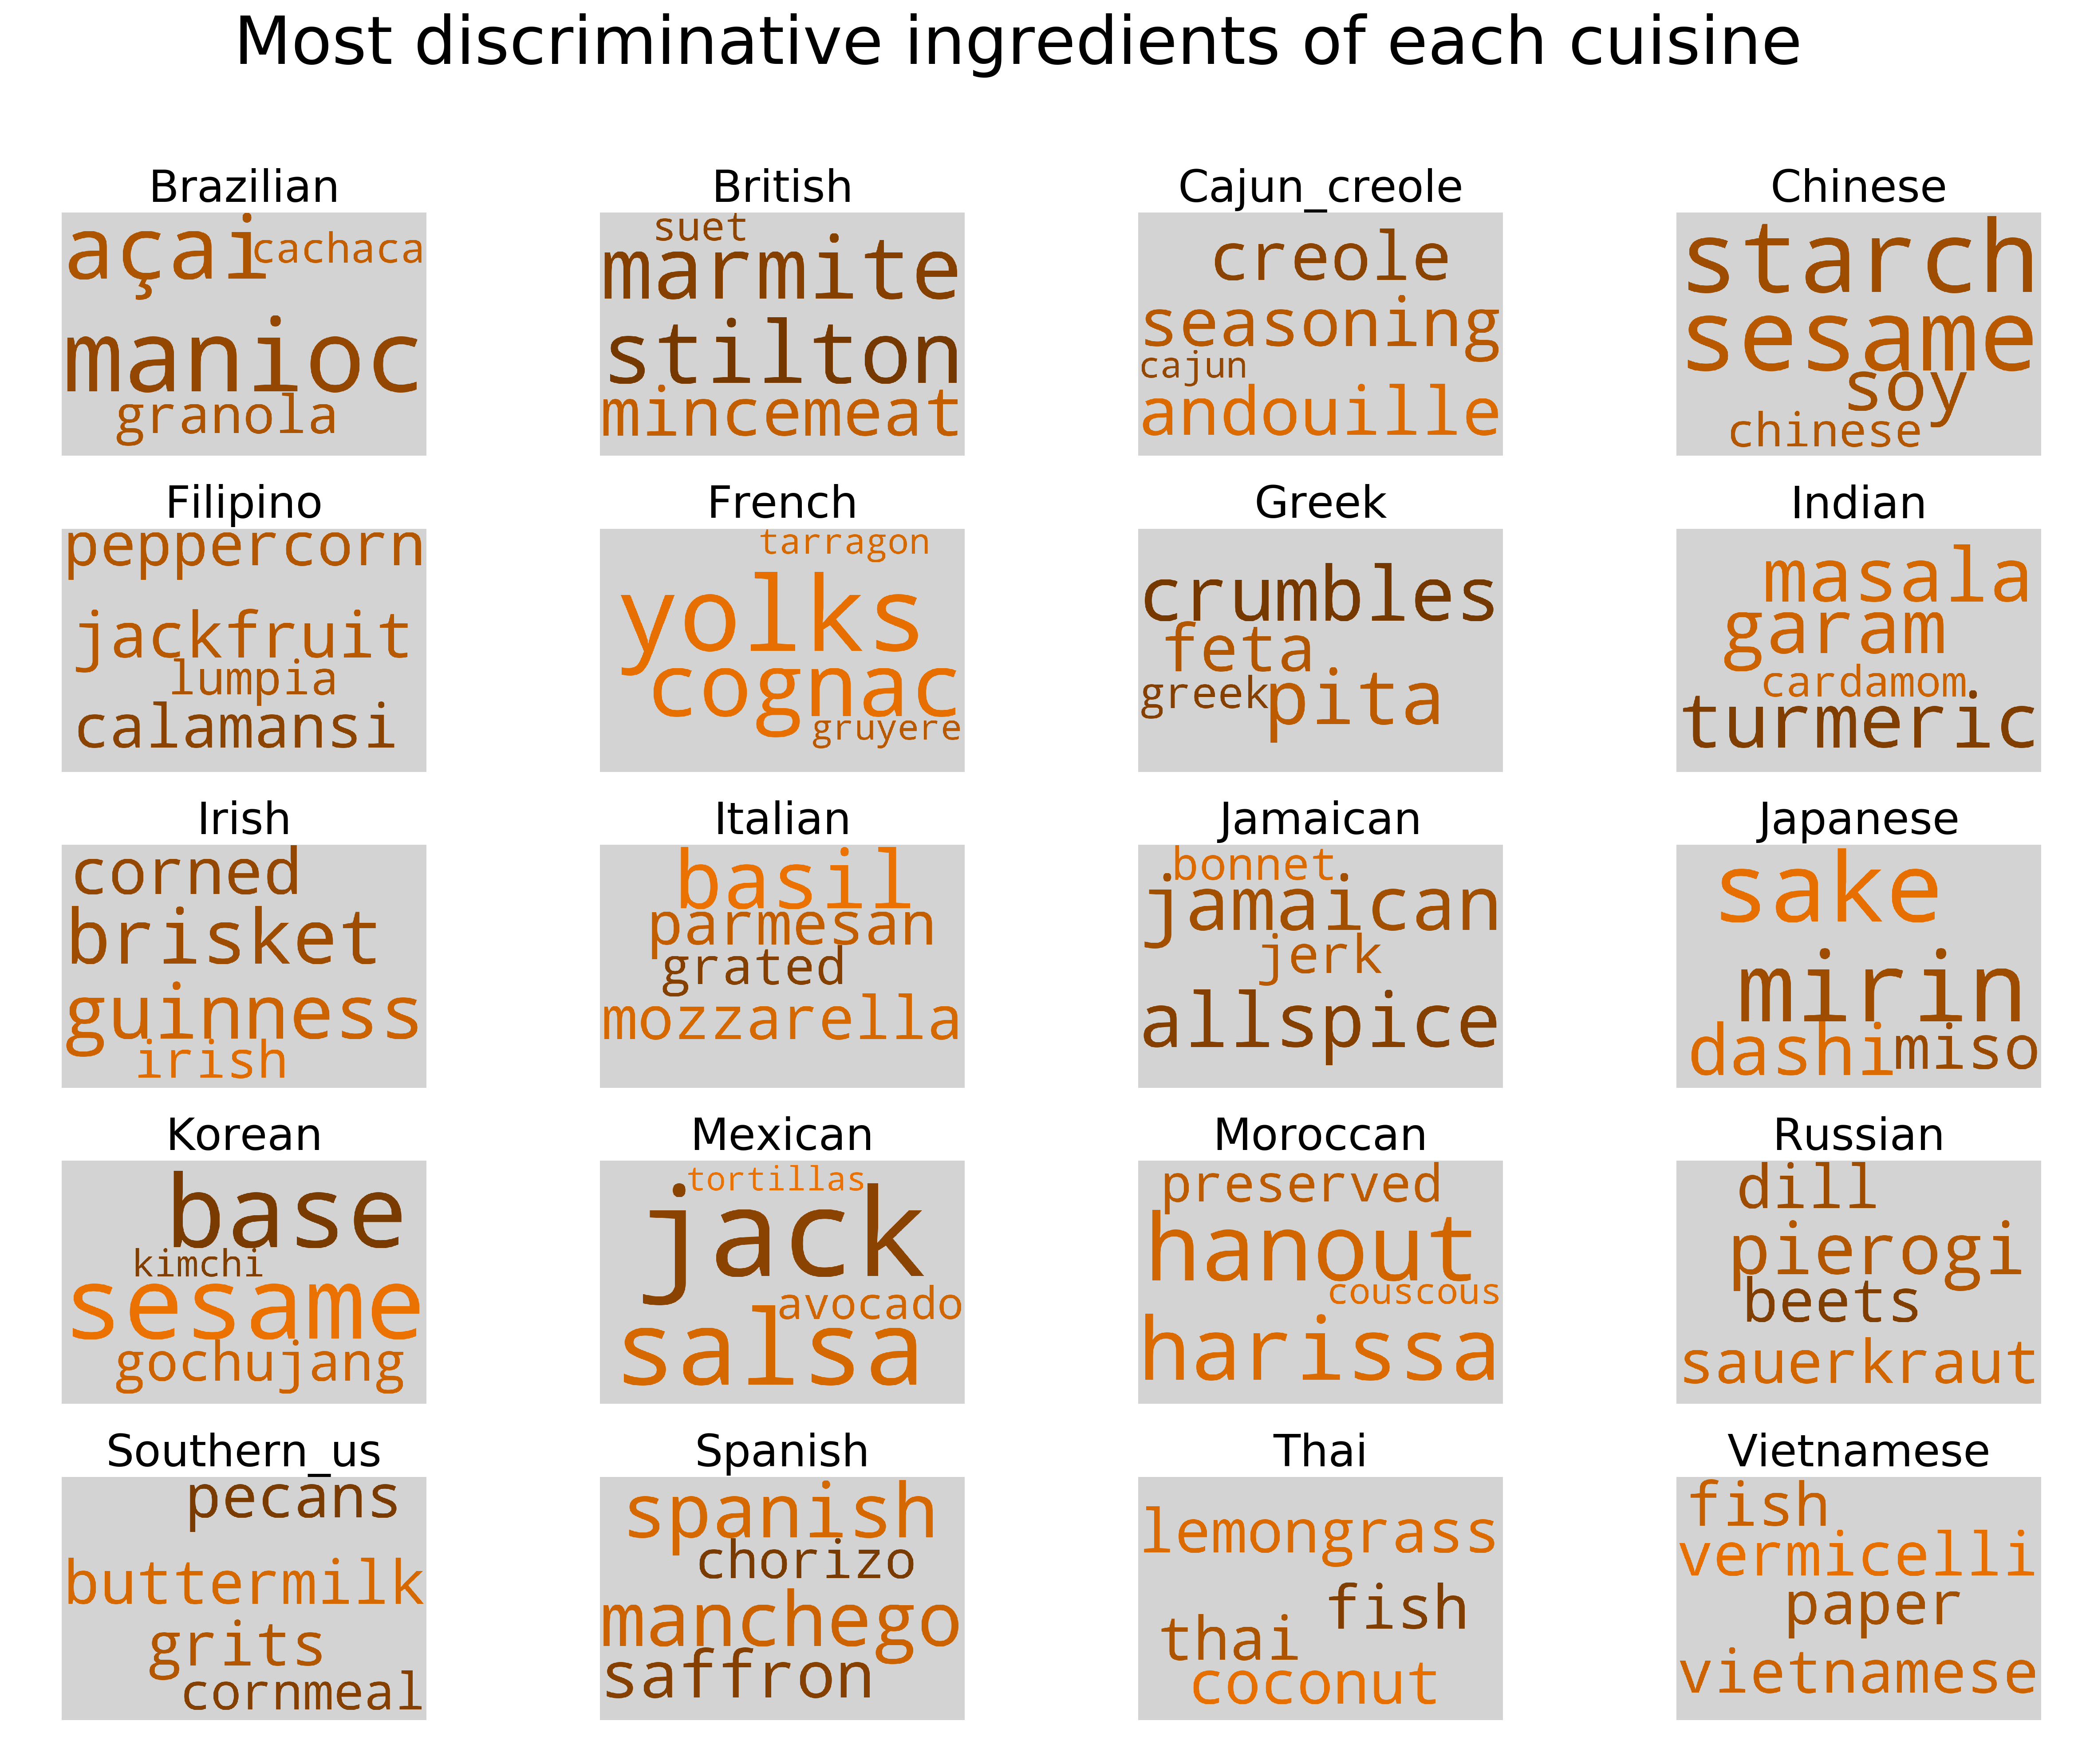

In [13]:
cuisine_list, com_unigram_list = feature_selection(features, labels, tfidf, le)
plot_word_cloud(cuisine_list, com_unigram_list) #select most discriminative ingredients of each cuisine

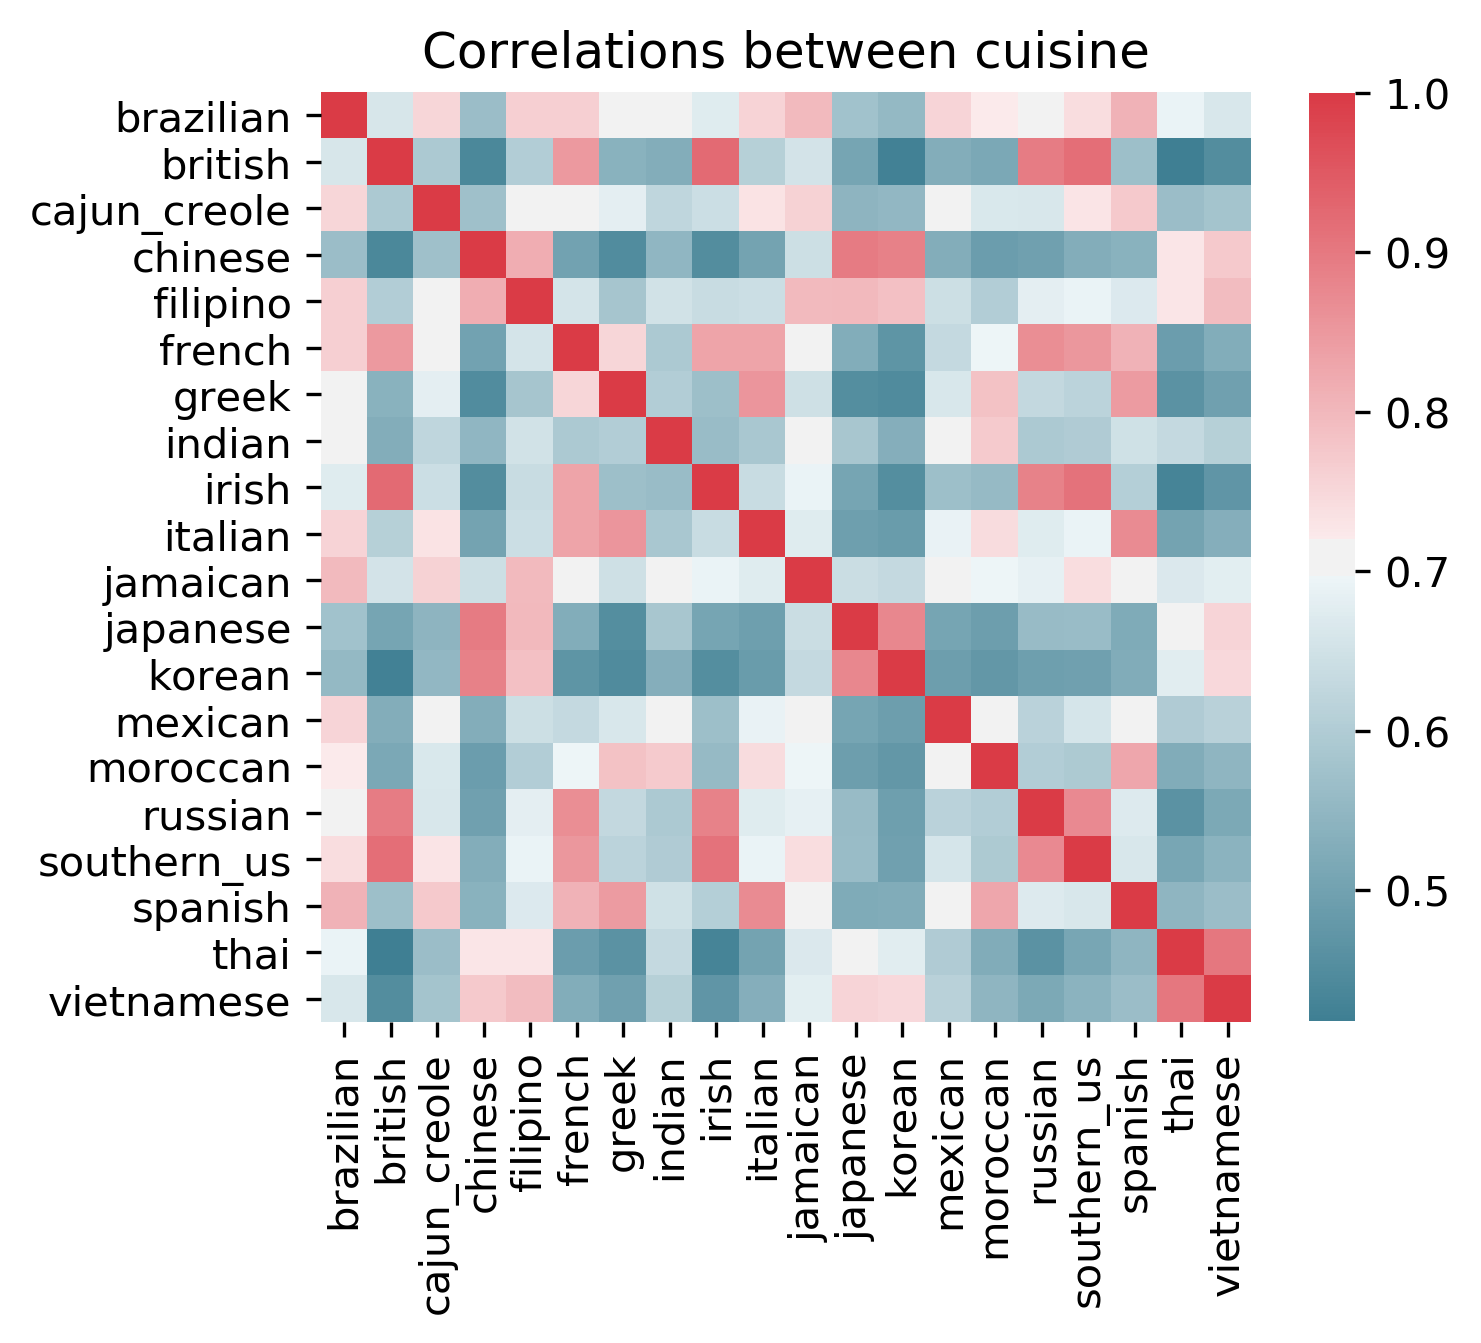

In [14]:
def plot_cuisine_corr(ingredients):
    countv = CountVectorizer(min_df=5, binary=True,
                            ngram_range=(1, 2), stop_words='english')
    countv.fit_transform(ingredients) #tokenize word counts in full ingredients list
    cuisine_word_counts = np.zeros(shape=(len(countv.vocabulary_), len(le.classes_)))
    for i in range(len(le.classes_)):
        cuisine_word_counts[:, i] = countv.transform(ingredients[labels==i]).mean(axis=0)
        #tokenize word counts in each cuisine        
    df = pd.DataFrame(data=cuisine_word_counts, columns=le.classes_)
    fig, ax =plt.subplots(figsize=(5,5), dpi=300)
    corr = df.corr()
    sns.heatmap(corr, 
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True,
                cbar_kws={"shrink": .82},
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    #fig.savefig('cuisine_mean_correlation.png')
    ax.set_title('Correlations between cuisine')
    plt.show()
plot_cuisine_corr(ingredients) #plot each cuisine correlation

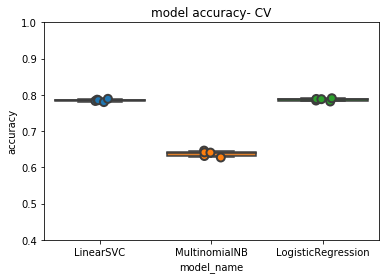

In [15]:
def cross_validation(features, labels):
    #cross validation to select best model from LogisticRegression, SVC, NB
#model to predict cuisine name based on ingredients,
    models = [
        LinearSVC(penalty='l2', C=1),
        MultinomialNB(),   
        LogisticRegression(random_state=0, penalty='l2', C=10)]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for index, model in enumerate(models):
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    fig, ax = plt.subplots()
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    ax.set_ylim(0.4, 1)
    #fig.savefig('cross_validation.png')
    ax.set_title('model accuracy- CV')
    plt.show()

cross_validation(features, labels)

In [16]:
def train_test(features, labels):
    print('Train and test model...')
    #best model is SVC and LogisticRegression(random_state=0, penalty='l2', C=10)
    #confusion matrix from best model SVC
    from sklearn.model_selection import train_test_split
    model = LogisticRegression(random_state=0, penalty='l2', C=10)
    X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.25, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_test, y_pred

y_test, y_pred = train_test(features, labels) #with best model selected, train and test

Train and test model...


Plot f1 score...
              precision    recall  f1-score   support

   brazilian       0.92      0.54      0.68       120
     british       0.63      0.44      0.52       198
cajun_creole       0.76      0.71      0.73       362
     chinese       0.79      0.87      0.83       696
    filipino       0.77      0.56      0.65       181
      french       0.62      0.65      0.64       658
       greek       0.79      0.67      0.73       302
      indian       0.87      0.92      0.89       783
       irish       0.71      0.45      0.55       159
     italian       0.80      0.90      0.85      1932
    jamaican       0.90      0.69      0.78       147
    japanese       0.80      0.68      0.73       348
      korean       0.82      0.74      0.78       183
     mexican       0.91      0.93      0.92      1631
    moroccan       0.88      0.78      0.82       199
     russian       0.67      0.49      0.57       118
 southern_us       0.73      0.82      0.77      1076
     spani

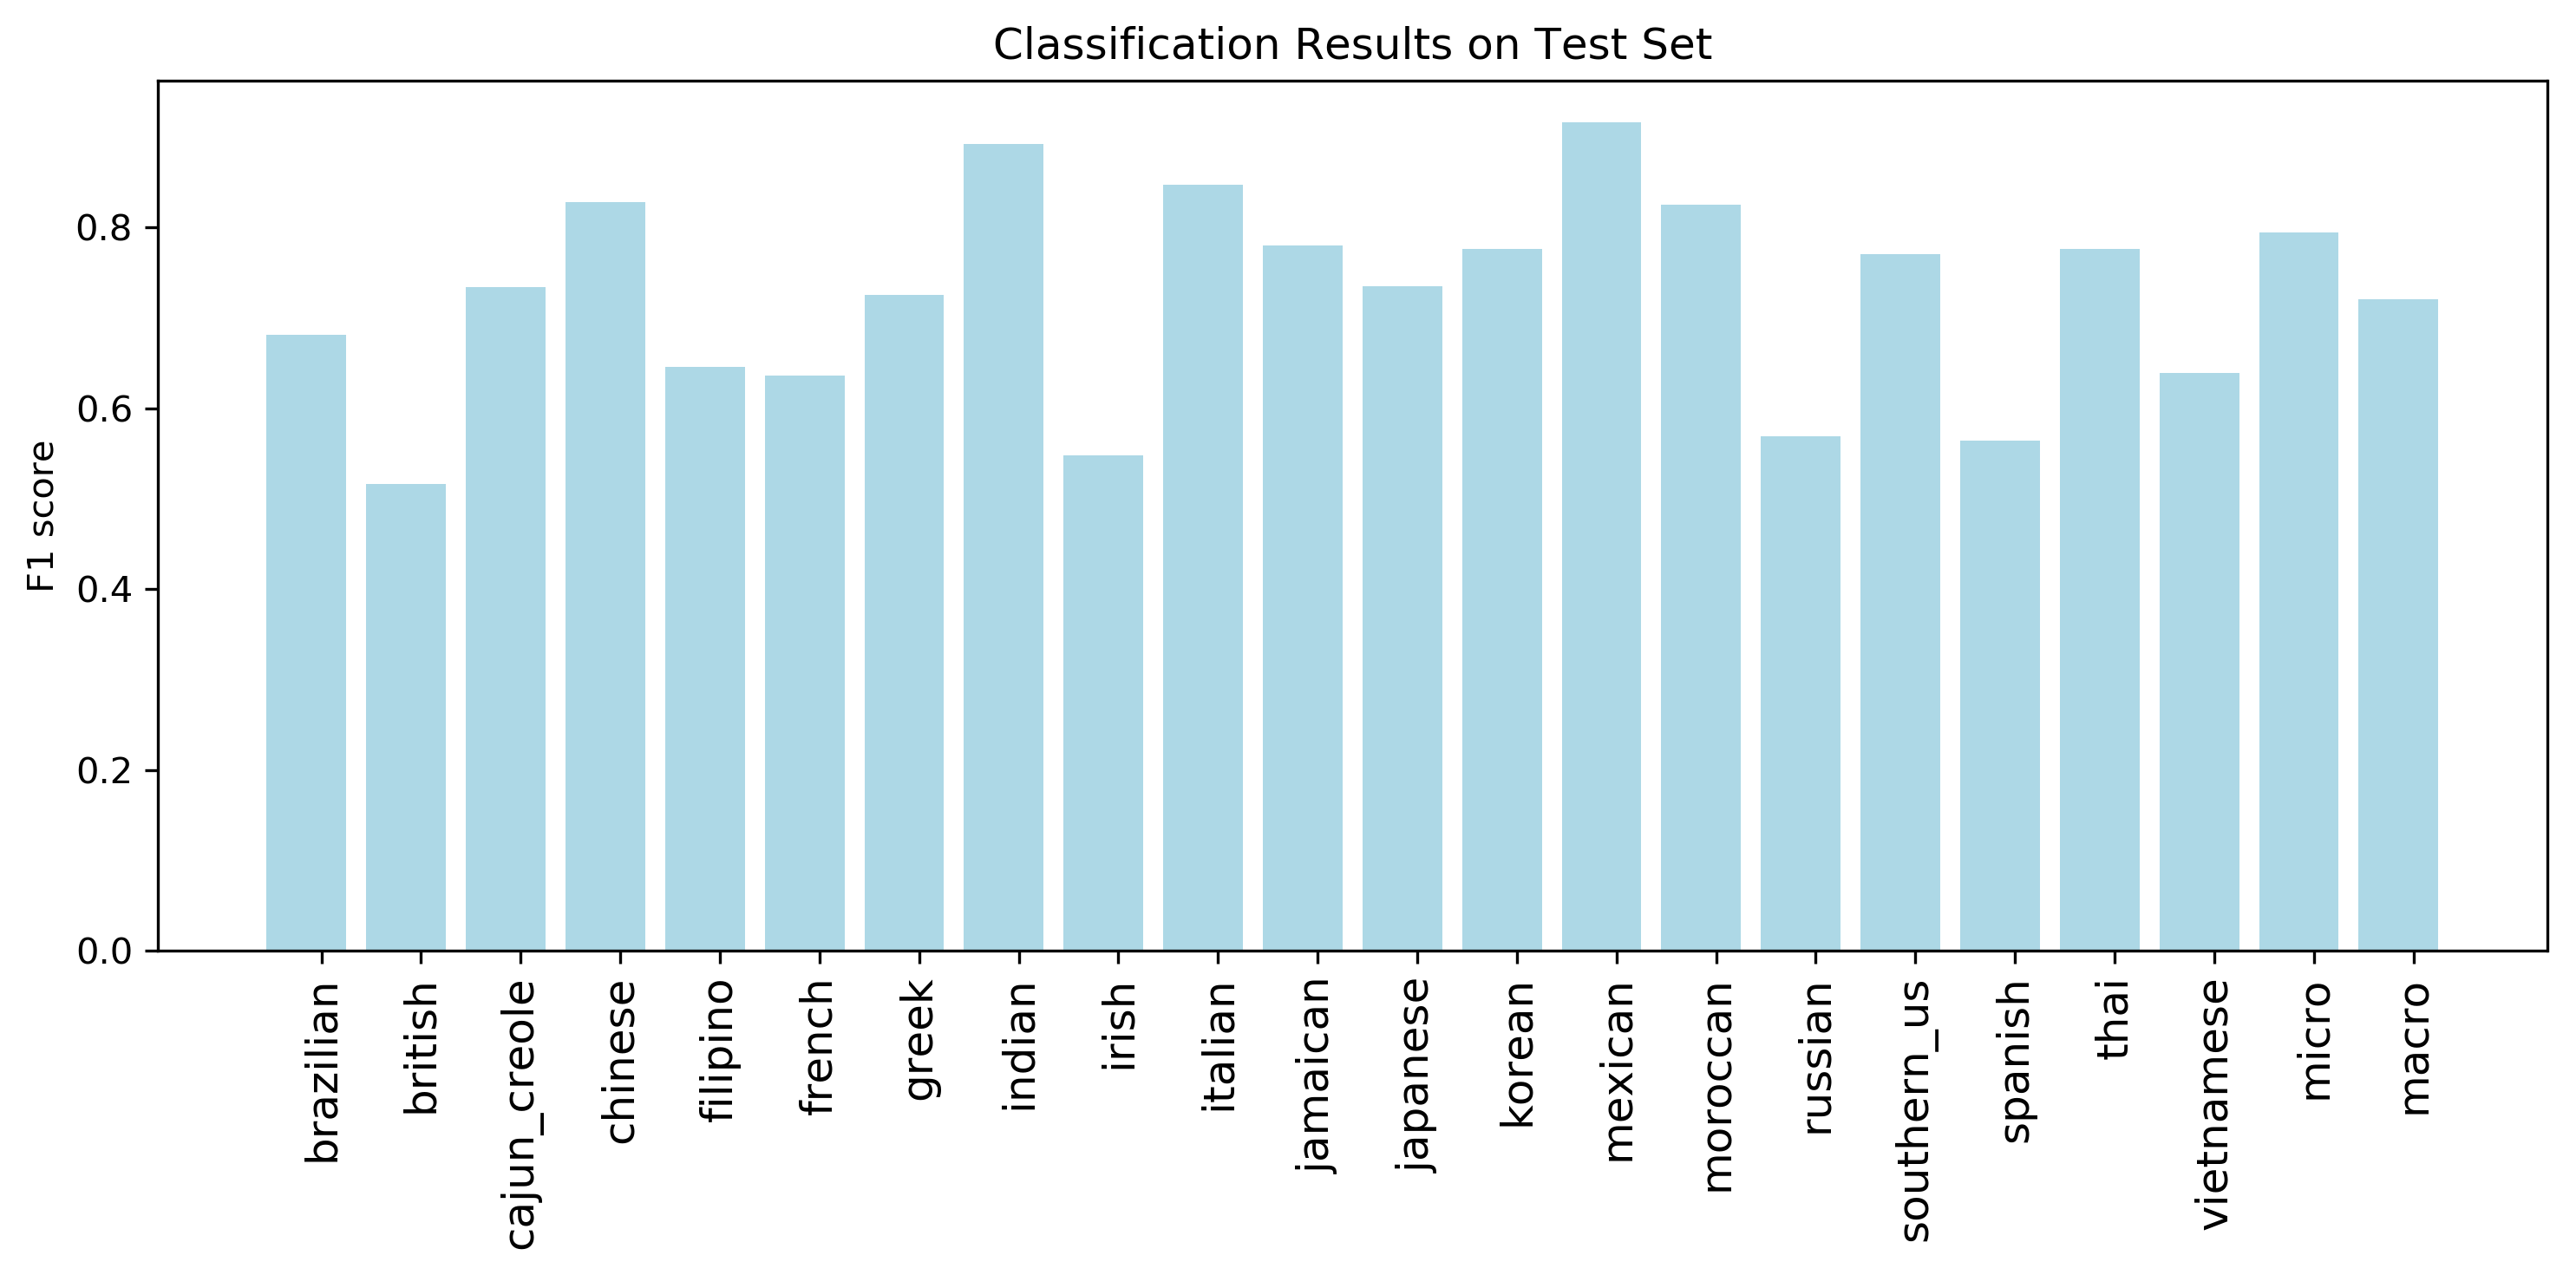

In [17]:
def plot_f1_score(y_test, y_pred, cuisine_list):
    print('Plot f1 score...')
    from sklearn import metrics
    print(metrics.classification_report(y_test, y_pred, target_names=cuisine_list))
    fig, ax2 = plt.subplots(figsize=(10,5), dpi=300)
    f1_score = list(metrics.f1_score(y_test, y_pred, average=None))
    f1_score.append(metrics.f1_score(y_test, y_pred, average='micro'))
    f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
    fig_labels = cuisine_list.tolist()
    fig_labels.extend(['micro', 'macro'])
    width = 0.3
    N = np.arange(len(fig_labels))
    ax2.bar(N, f1_score, color='lightblue')
    ax2.set_xticks(N + width/2)
    ax2.set_xticklabels(fig_labels, fontsize=12, rotation=90)
    ax2.set_ylabel('F1 score')
    ax2.set_title('Classification Results on Test Set')
    plt.tight_layout()
    #fig.savefig('f1_score.png')
    plt.show()
    
plot_f1_score(y_test, y_pred, cuisine_list)

Plot confusion matrix...


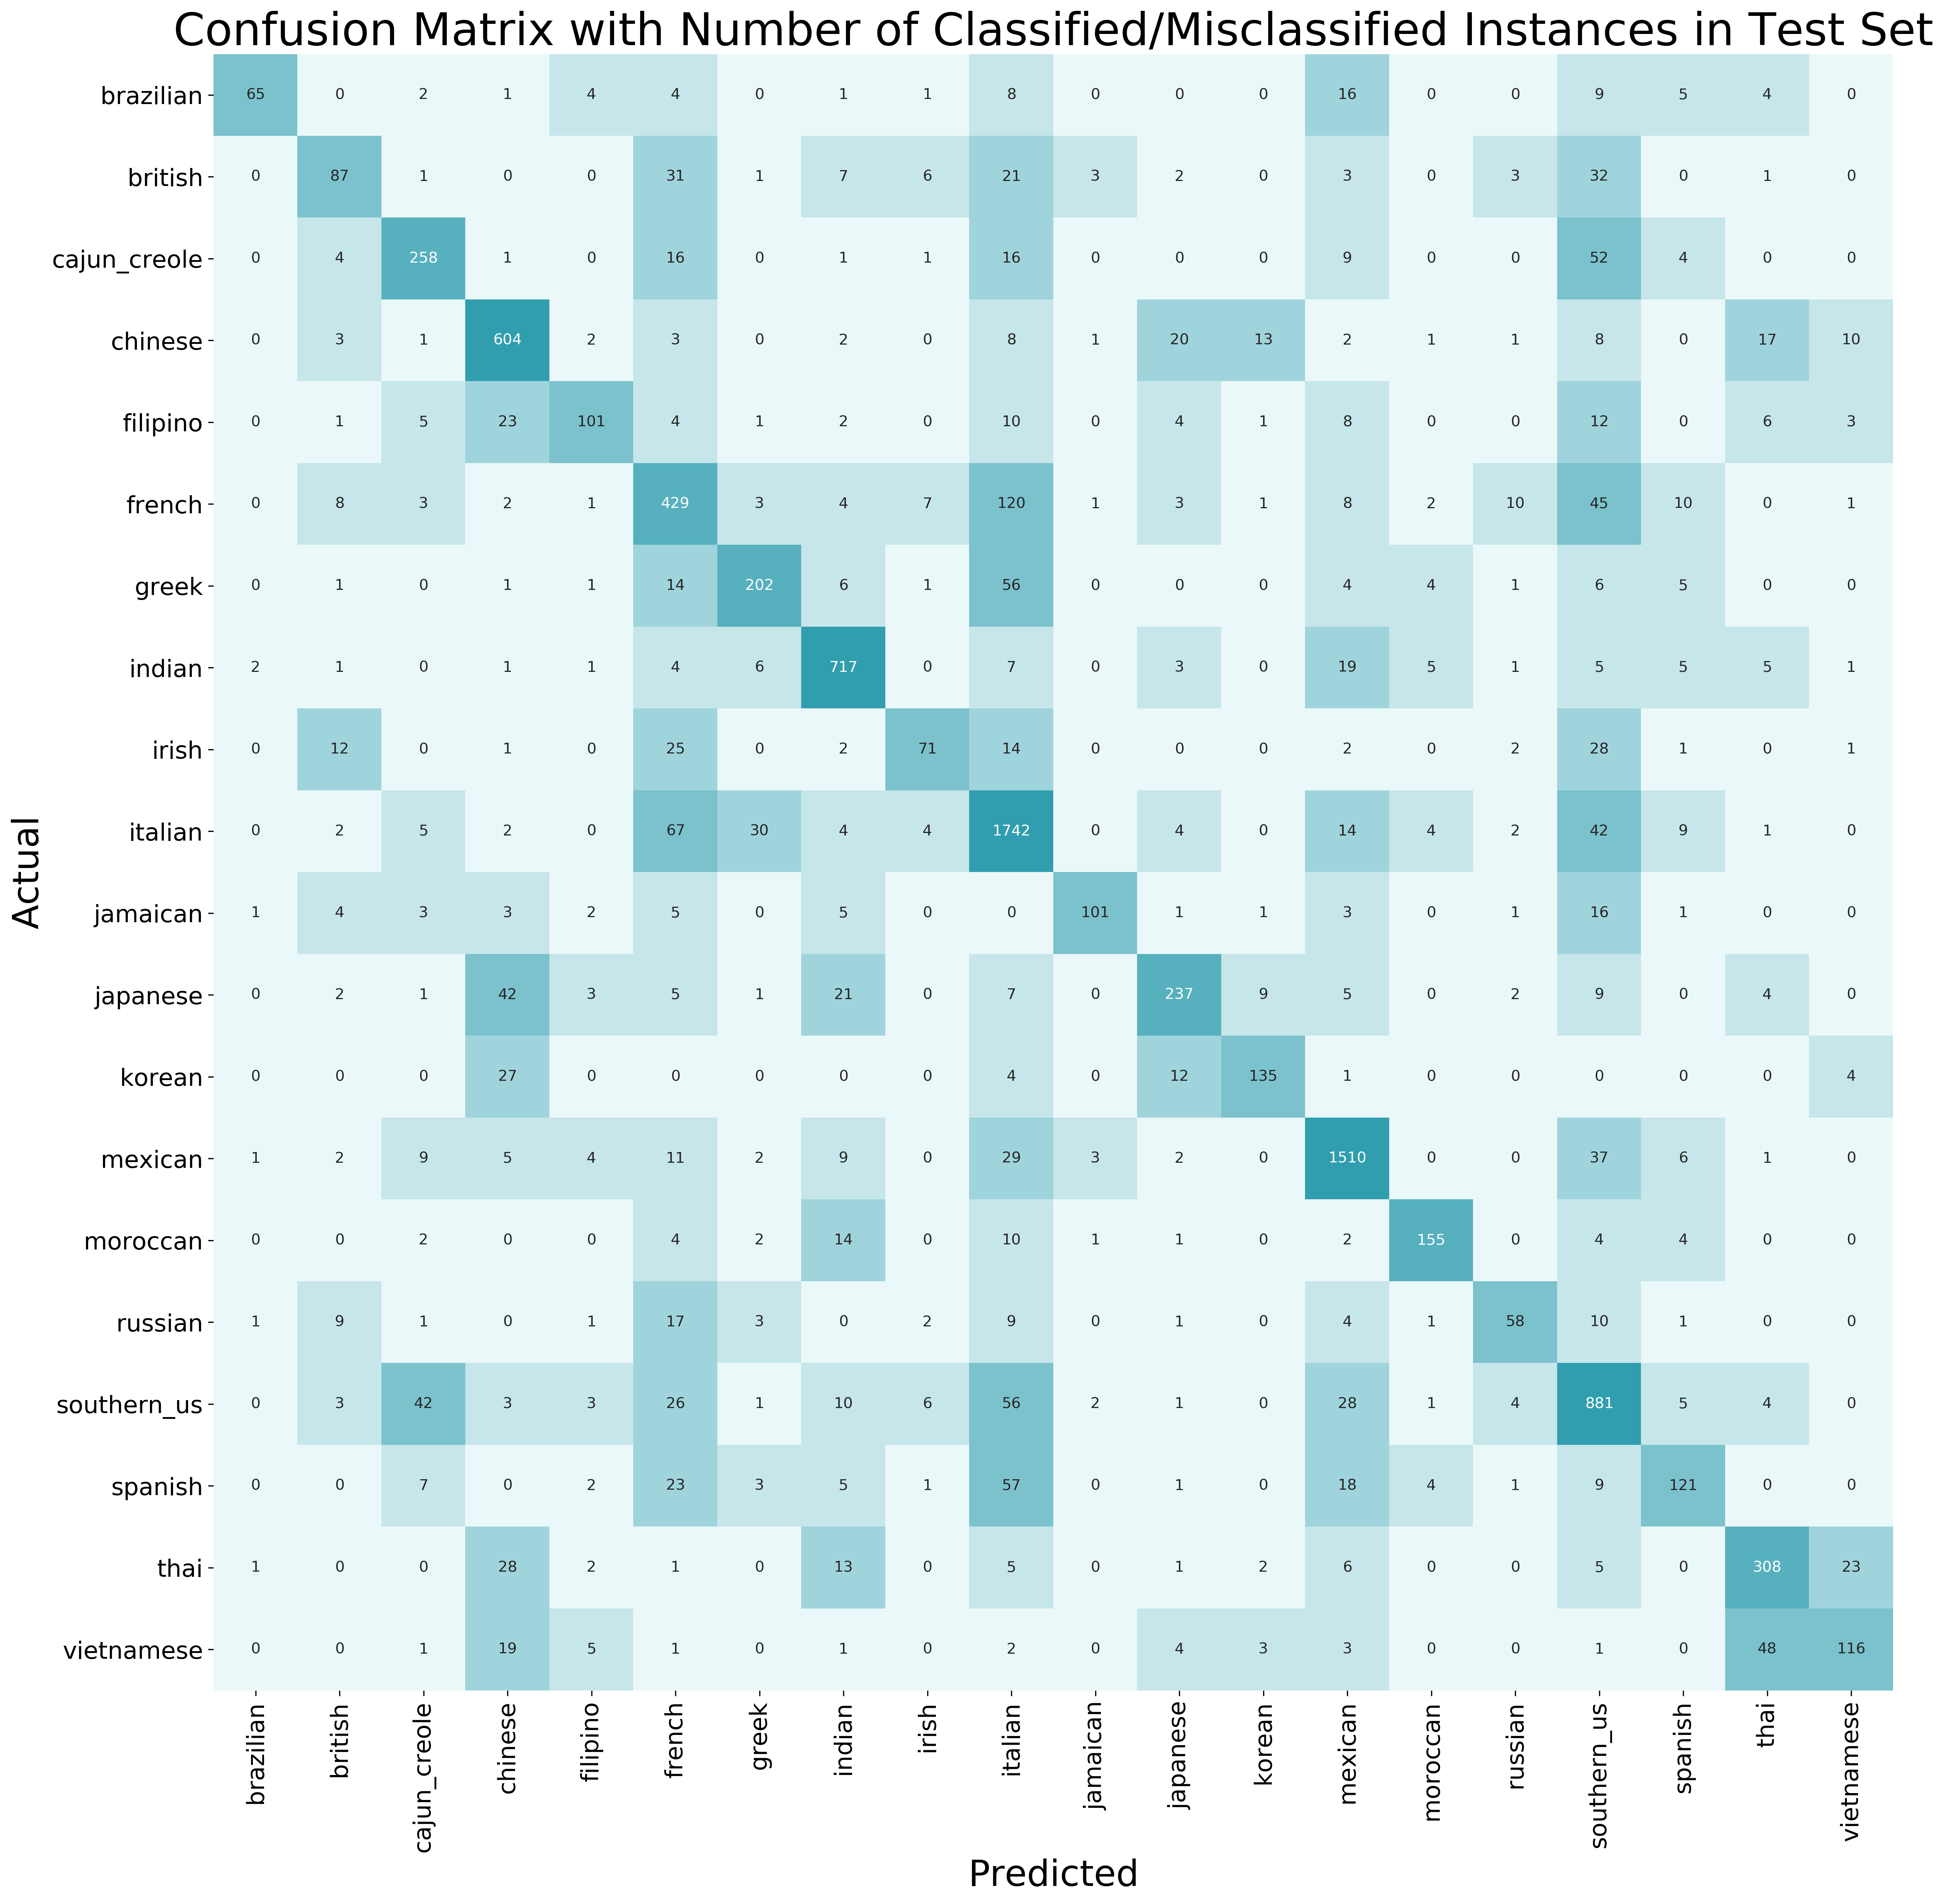

In [18]:
def plot_confusion_matrix(y_test, y_pred, cuisine_list):
    print('Plot confusion matrix...')
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    log_conf_mat = np.log10(conf_mat+1)
    fig, ax1 = plt.subplots(figsize=(20,20), dpi=300)
    cmap = sns.light_palette((210, 90, 60), input="husl")
    sns.heatmap(log_conf_mat, annot=conf_mat, fmt='d', cmap=cmap,cbar=False,
                xticklabels=cuisine_list, yticklabels=cuisine_list)  
    ax1.set_ylabel('Actual', fontsize=24)
    ax1.set_xlabel('Predicted', fontsize=24)
    ax1.set_xticklabels(cuisine_list,fontsize=16, rotation=90)
    ax1.set_yticklabels(cuisine_list, fontsize=16)
    ax1.set_title('Confusion Matrix with Number of Classified/Misclassified Instances in Test Set', 
              fontsize=30)
    #fig.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(y_test, y_pred, cuisine_list)